<a href="https://colab.research.google.com/github/saritmaitra/Trading-strategy/blob/master/Brent__TradingStrategy_BiasVariance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyforest
from pyforest import *
import datetime, pickle, copy
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
import matplotlib.pyplot as plt
%matplotlib inline  
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
!pip install quandl
import quandl
plt.style.use('ggplot')
from statistics import variance 
from random import randint
import scipy as sp
from scipy import stats
!pip install ffn
import ffn
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
!pip install tscv
from tscv import GapKFold


## Continuous Contracts
Individual futures contracts trade for very short periods of time, and are hence unsuitable for long-horizon analysis. Continuous futures contracts solve this problem by chaining together a series of individual futures contracts, to provide a long-term price history that is suitable for trading, behavioral and strategy analysis.

In [2]:
# Natural Gas continuous contract
print('\033[4mBrent Crude Futures, Continuous Contract\033[0m')
def BCdata():
  BC = quandl.get("CHRIS/ICE_B1", authtoken="LSQpgUzwJRoF667ZpzyL") # natural gas continuous contract 1
  BC = BC.loc['2010-01':,]
  return BC

BC = BCdata()
print(BC.head()); print(BC.shape)


Brent Crude Futures, Continuous Contract
             Open   High    Low  Settle  Change  Wave    Volume  Prev. Day Open Interest  EFP Volume  EFS Volume  Block Volume
Date                                                                                                                          
2010-01-04  78.49  80.48  78.34   80.12     NaN   NaN  117445.0                 188136.0      3987.0       830.0         375.0
2010-01-05  80.29  80.84  79.75   80.59    0.47   NaN  124294.0                 176882.0      1767.0      2585.0        3108.0
2010-01-06  80.38  82.21  79.77   81.89    1.30   NaN  148099.0                 172055.0      1530.0      1768.0        6475.0
2010-01-07  82.00  82.05  81.05   81.51   -0.38   NaN  127310.0                 163579.0       673.0      1201.0        2100.0
2010-01-08  81.51  82.05  80.59   81.37   -0.14   NaN  149060.0                 144865.0      1779.0      2496.0        4150.0
(2895, 11)


Open                         24
High                         24
Low                          24
Settle                       24
Change                       54
Wave                       1511
Volume                       25
Prev. Day Open Interest       1
EFP Volume                  432
EFS Volume                 1782
Block Volume                 61
dtype: int64


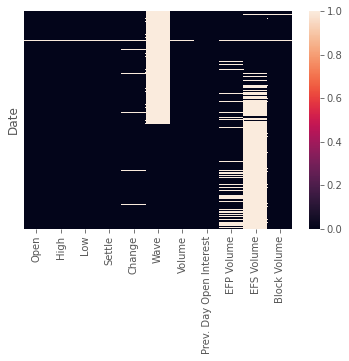

In [3]:
import seaborn as sns
%matplotlib inline
print(BC.isnull().sum())
sns.heatmap(BC.isnull(), yticklabels = False)
plt.show()

In [4]:
def collectColumns():
  newDf = BC[['Open', 'High', 'Low', 'Settle', 'Volume']]
  newDf= newDf.fillna(method='ffill')
  return newDf

newDf = collectColumns()
print(newDf.head()); print()
print(newDf.isnull().sum()); print()
print(newDf.describe().transpose())

             Open   High    Low  Settle    Volume
Date                                             
2010-01-04  78.49  80.48  78.34   80.12  117445.0
2010-01-05  80.29  80.84  79.75   80.59  124294.0
2010-01-06  80.38  82.21  79.77   81.89  148099.0
2010-01-07  82.00  82.05  81.05   81.51  127310.0
2010-01-08  81.51  82.05  80.59   81.37  149060.0

Open      0
High      0
Low       0
Settle    0
Volume    0
dtype: int64

         count           mean           std      min         25%        50%         75%        max
Open    2895.0      76.381551     26.669618    19.90      54.075      70.82     106.595     126.58
High    2895.0      77.316739     26.736489    21.29      54.720      71.60     107.670     128.40
Low     2895.0      75.395893     26.593451    15.98      53.030      69.68     105.590     125.00
Settle  2895.0      76.388238     26.711405    19.33      53.935      70.54     106.680     126.65
Volume  2895.0  213551.528152  90689.912591  9974.00  158802.000  208936.00  268

The data frame will have the index set to dates and the columns are:
- Open: The price of the first trade on the given trading day.
- High: The highest price at which a stock traded for the given trading day.
- Low: The lowest price at which a stock traded for the given trading day.
- Adj Close: According to Yahoo Finance, this is the “the closing price after adjustments for all applicable splits and dividends distributions”.
- Volume: The number of shares traded for the given trading day.

In [5]:
import plotly.graph_objects as go

def plot():
  fig = go.Figure(data=go.Ohlc(x=newDf.index,
                  open=newDf['Open'],
                  high=newDf['High'],
                  low=newDf['Low'],
                  close=newDf['Settle']))

  fig.update_layout(
      title='Brent Crude Futures, Continuous Contract',
      yaxis_title='Price (USD)'
  )
  return fig

fig = plot()
fig.show()

In [6]:
# Calculate the daily percentage change which is daily return
data = newDf["2020-03-01":].copy()

print('\033[1m' + 'Daily percentage change:' + '\033[1m')
dailyReturn = data['Settle'].pct_change().dropna()
# mean_return = daily_ret.mean()
# return_stdev = daily_ret.std()
print('Average daily return : %1.2f%% ' % round((dailyReturn.mean()*100),2))
print('Average Volatility : %1.2f%% ' % round((dailyReturn.std()*100), 2))

Daily percentage change:
Average daily return : 0.18% 
Average Volatility : 4.38% 


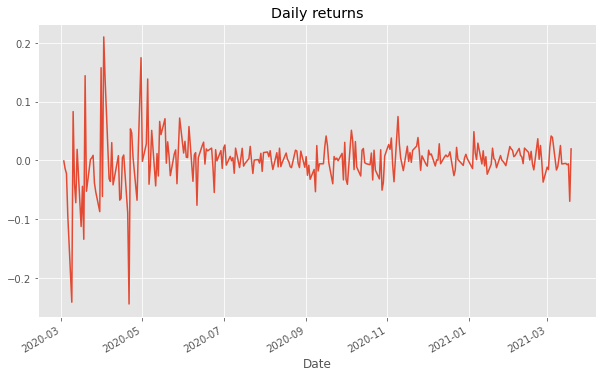

In [7]:
dailyReturn.plot(figsize=(10,6),grid=True)
plt.title('Daily returns')
plt.show()

In [8]:
perf = data['Settle'].copy().calc_stats()
print('\n')
perf.display()



Stats for Settle from 2020-03-02 00:00:00 - 2021-03-19 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
24.34%              0.65  23.15%  -62.76%

Annualized Returns:
mtd    3m      6m      ytd     1y       3y    5y    10y    incep.
-----  ------  ------  ------  -------  ----  ----  -----  --------
0.17%  23.48%  49.55%  24.58%  126.66%  -     -     -      23.15%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.65     2.05       -
mean    44.89%   102.91%    24.58%
vol     69.50%   50.27%     -
skew    -0.42    1.25       -
kurt    10.29    1.93       -
best    21.02%   42.90%     24.58%
worst   -24.40%  -10.31%    24.58%

Drawdowns:
max      avg        # days
-------  -------  --------
-62.76%  -10.20%     38.78

Misc:
---------------  -------
avg. up month    11.98%
avg. down month  -8.44%
up year %        100.00%
12m up %         100

In [9]:
perf.stats

start                    2020-03-02 00:00:00
end                      2021-03-19 00:00:00
rf                                         0
total_return                        0.243353
cagr                                0.231534
max_drawdown                       -0.627553
calmar                              0.368948
mtd                               0.00170754
three_month                         0.234788
six_month                           0.495481
ytd                                 0.245753
one_year                              1.2666
three_year                               NaN
five_year                                NaN
ten_year                                 NaN
incep                               0.231534
daily_sharpe                        0.645913
daily_sortino                       0.993193
daily_mean                          0.448882
daily_vol                           0.694957
daily_skew                         -0.422566
daily_kurt                           10.2908
best_day  

In [10]:
from scipy.stats import normaltest
normaltest(dailyReturn)

NormaltestResult(statistic=67.8236243646344, pvalue=1.871919195999281e-15)

In [11]:
# empirical quantile of daily returns
import scipy.stats
print('\033[4mEmpirical quantile of daily returns\033[0m')
round(dailyReturn.quantile(0.05),2)

Empirical quantile of daily returns


-0.06

Critical Values


<IPython.core.display.Javascript object>

t test statistic:  0.67


P-value is:  0.5


Critical value at α = 0.01 with 251 df:  326.98




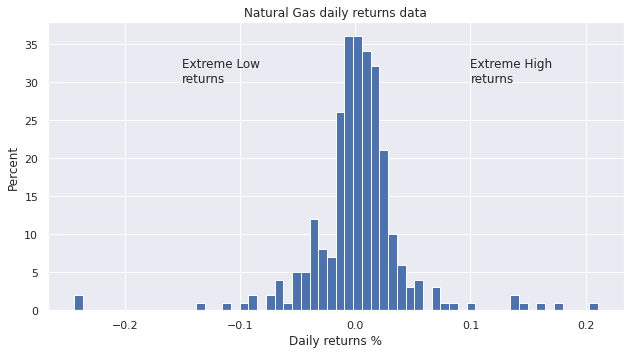



Skewness :  -0.42
Kurtosis :  10.29


In [12]:
print('\033[4mCritical Values\033[0m')
n = len(dailyReturn)
test_statistic = ((dailyReturn.mean() - 0) / (dailyReturn.std()/np.sqrt(n)))
print ('t test statistic: ', round(test_statistic,2))
print('\n')

from scipy.stats import t
p_val = 2 * (1 - t.cdf(test_statistic, n - 1))
print ('P-value is: ', round(p_val,1))
print('\n')

from scipy.stats import chi2
# Here we calculate the critical value directly because our df is too high for most chisquare tables
crit_value = chi2.ppf(0.99, (n - 1))
print ('Critical value at α = 0.01 with 251 df: ', round(crit_value,2))
print('\n')

# Plot the distributions
fig = plt.figure(figsize=(10,5))
sns.set(rc={'figure.figsize': (15,5)})
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
dailyReturn.plot.hist(bins = 60)
ax1.set_xlabel("Daily returns %")
ax1.set_ylabel("Percent")
ax1.set_title("Natural Gas daily returns data")
ax1.text(-0.15,30,"Extreme Low\nreturns")
ax1.text(0.10,30,"Extreme High\nreturns")
plt.show()
print('\n')
print("Skewness : ", round(dailyReturn.skew(),2))
print("Kurtosis : ", round(dailyReturn.kurtosis(),2))

In [13]:
!pip install pyfolio
import pyfolio as pf


     |████████████████████████████████| 92kB 5.7MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2-cp37-none-any.whl size=88667 sha256=7b4e9fd914155805fee8cff6b8c222eddca346492b5660f11283f6deae4c45a0
  Stored in directory: /root/.cache/pip/wheels/0d/a8/7d/ac33fe6bf6f3db370291c9de303460d00b8f97cc40a1d80f72
  Created wheel for empyrical: filename=empyrical-0.5.5-cp37-none-any.whl size=39764 sha256=21ae63880a6c826b8f6130450ed7076973a6921c0fa72f1e2185392cd42fc583
  Stored in directory: /root/.cache/pip/wheels/ea/b2/c8/6769d8444d2f2e608fae2641833110668d0ffd1abeb2e9f3fc
Successfully built pyfolio empyrical


/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning:

Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.



Start date,2020-03-03
End date,2021-03-19
Total months,12
,Backtest
Annual return,22.5%
Cumulative returns,24.3%
Annual volatility,69.5%
Sharpe ratio,0.65
Calmar ratio,0.36
Stability,0.72
Max drawdown,-62.8%


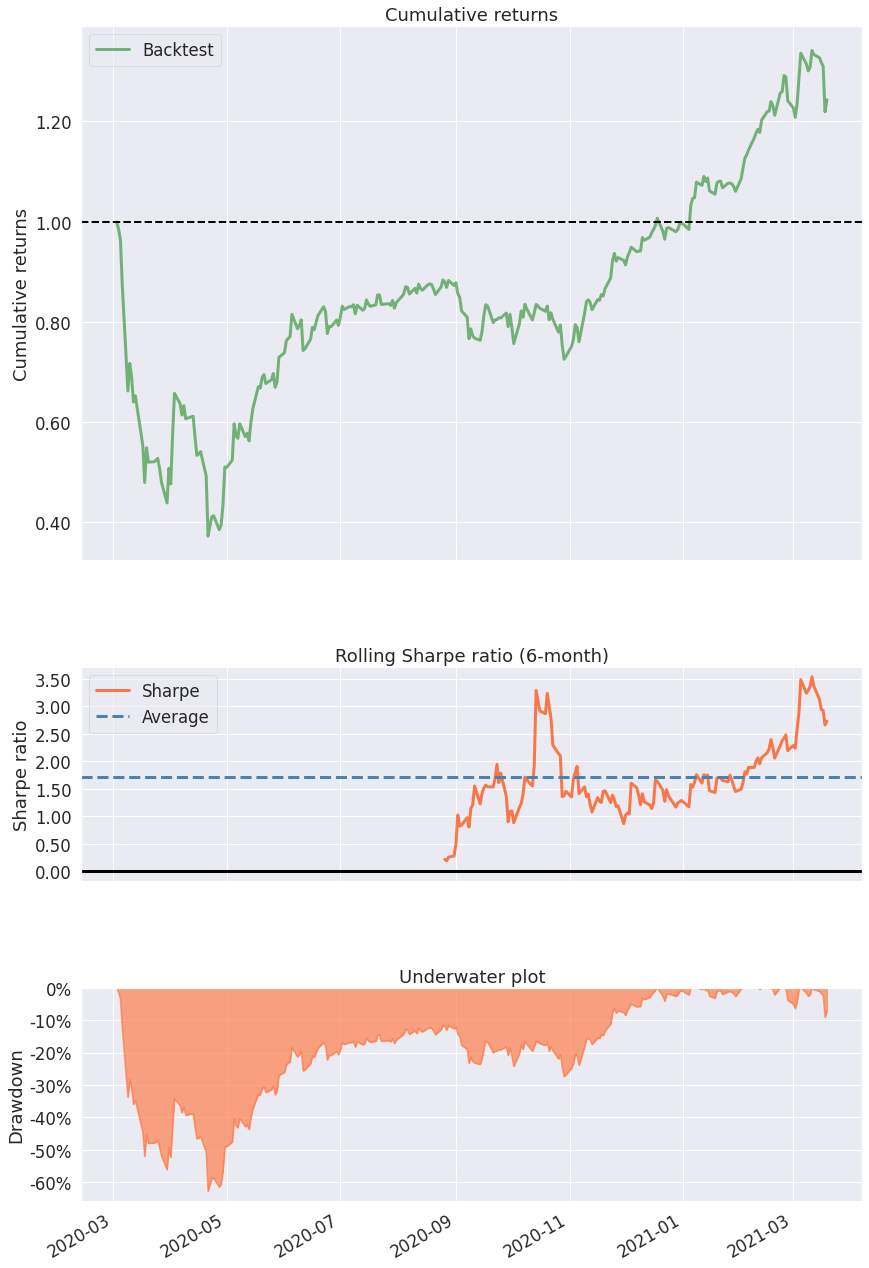

In [14]:
pf.create_simple_tear_sheet(dailyReturn)

In [15]:
print('\033[4mProbability of +/-(1%); +/-(3%); +/-%(5) change in price (Data -> 2020 March- till date)\033[0m')

print ("The probability of price changes between 1%% and -1%% is %1.2f%% " % 
       (100*dailyReturn[(dailyReturn > -0.01) & (dailyReturn < 0.01)].shape[0] / dailyReturn.shape[0]))
print ("The probability of price changes between 3%% and -3%% is %1.2f%% " % 
       (100*dailyReturn[(dailyReturn > -0.03) & (dailyReturn < 0.03)].shape[0] / dailyReturn.shape[0]))
print ("The probability of price changes between 5%% and -5%% is %1.2f%% " % 
       (100*dailyReturn[(dailyReturn > -0.05) & (dailyReturn < 0.05)].shape[0] / dailyReturn.shape[0]))
print ("The probability of price changes more than 5%% is %1.2f%%" % 
       (100*dailyReturn[dailyReturn > 0.05].shape[0] / dailyReturn.shape[0]))
print ("The probability of price changes less than -5%% is %1.2f%%" % 
       (100*dailyReturn[dailyReturn < -0.05].shape[0] / dailyReturn.shape[0]))

Probability of +/-(1%); +/-(3%); +/-%(5) change in price (Data -> 2020 March- till date)
The probability of price changes between 1% and -1% is 35.42% 
The probability of price changes between 3% and -3% is 73.80% 
The probability of price changes between 5% and -5% is 87.08% 
The probability of price changes more than 5% is 5.90%
The probability of price changes less than -5% is 7.01%


In [16]:
print('\033[4mMinimum price [2020 March- till date]\033[0m')
print(round(data['Settle'].min(),2), data['Settle'].idxmin());
print('\033[4mMaximum price [2017- till date]\033[0m')
print(round(data['Settle'].max(),2), data['Settle'].idxmax());
print('\n')

print('\033[4mMinimum daily % return [2020- till date]\033[0m')
print(round(dailyReturn.min(),2)*100, dailyReturn.idxmin()); 
print('\033[4mMaximum daily % return [2020- till date]\033[0m')
print(round(dailyReturn.max()*100, 2), dailyReturn.idxmax());


Minimum price [2020 March- till date]
19.33 2020-04-21 00:00:00
Maximum price [2017- till date]
69.63 2021-03-11 00:00:00


Minimum daily % return [2020- till date]
-24.0 2020-04-21 00:00:00
Maximum daily % return [2020- till date]
21.02 2020-04-02 00:00:00


In [17]:
days = (data.index[-1] - data.index[0]).days

# Calculate the CAGR 
cagr = ((((data['Settle'][-1]) / data['Settle'][1])) ** (252.0/days)) - 1

# Print the CAGR
print(round(cagr*100))

16


In [18]:
!pip install EIA_python
import eia

In [19]:
def features():
    df = newDf.copy()  
    df['Settle'] = df['Settle'].pct_change()
    df['High'] = df['High'].pct_change()
    df['Low'] = df['Low'].pct_change()
    df['Volume'] = df['Volume'].pct_change()
    df['dailyChange'] = (df['Settle'] - df['Open']) / df['Open']
    df['5EMA'] = (df['Settle'].ewm(span=5,adjust=True,ignore_na=True).mean())
    df['10EMA'] = (df['Settle'].ewm(span=10,adjust=True,ignore_na=True).mean())
    df['priceDirection'] = (df['Settle'].shift(-1) - df['Settle'])
    
    rsi_period = 14 
    chg = df['Settle'].diff(1)
    gain = chg.mask(chg<0,0)
    loss = chg.mask(chg>0,0)
    avg_gain = gain.ewm(com = rsi_period - 1, min_periods = rsi_period).mean()
    avg_loss = loss.ewm(com = rsi_period - 1, min_periods = rsi_period).mean()
    rs = abs(avg_gain/avg_loss)
    df['rsi'] = 100-(100/(1+ rs))

    df['Std_dev']=  df['Settle'].rolling(5).std()
    df['ROC'] = ((df['Settle'] - df['Settle'].shift(5)) / (df['Settle'].shift(5)))*100
    df['Williams%R'] = (df['High'].max() - df['Settle'])/(df['High'] - df['Low'].min()) * -100

    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    df['signal'] = 0.0
    df['signal'] = np.where((df.loc[:,'priceDirection'] > 0), 1.0, 0.0)
    df.drop(columns =['Open','priceDirection' ], axis=1, inplace=True)
    # df.dropna(inplace=True)
    return df

df = features()
print(df)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                High       Low    Settle    Volume  dailyChange      5EMA     10EMA        rsi   Std_dev         ROC  Williams%R  signal
Date                                                                                                                                    
2010-01-25 -0.017964  0.004018  0.011808 -0.210871    -0.999837 -0.006767 -0.007528  56.774968  0.016930 -227.628267 -124.925037     0.0
2010-01-26 -0.001355 -0.000138 -0.005428 -0.034143    -1.000074 -0.006320 -0.007130  48.821438  0.014830 -178.964146 -123.799475     0.0
2010-01-27 -0.001085 -0.016149 -0.014327  0.222587    -1.000196 -0.008992 -0.008483  45.293716  0.014635  -15.100943 -126.541732     1.0
2010-01-28 -0.006927  0.003227 -0.001523 -0.097007    -1.000021 -0.006500 -0.007183  50.802302  0.013324  -93.321114 -124.776103     0.0
2010-01-29  0.002325 -0.006852 -0.009289 -0.001901    -1.000129 -0.007430 -0.007574  47.667107  0.009904  -60.413856 -123.579190     1.0
...              ...       ...       ... 

In [20]:
# # function for a clean dataset of nan, Inf, and missing cells (for skewed datasets)
# def clean_dataset(df):
#     assert isinstance(df)
#     df.dropna(inplace=True)
#     indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
#     return df[indices_to_keep].astype(np.float64)


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2849 entries, 2010-01-25 to 2021-03-18
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   High         2849 non-null   float64
 1   Low          2849 non-null   float64
 2   Settle       2849 non-null   float64
 3   Volume       2849 non-null   float64
 4   dailyChange  2849 non-null   float64
 5   5EMA         2849 non-null   float64
 6   10EMA        2849 non-null   float64
 7   rsi          2849 non-null   float64
 8   Std_dev      2849 non-null   float64
 9   ROC          2849 non-null   float64
 10  Williams%R   2849 non-null   float64
 11  signal       2849 non-null   float64
dtypes: float64(12)
memory usage: 289.4 KB


- RSI = 100 - 100 / (1 + RS)
- where RS = Average gain over the last 14 days/Average loss over the last 14 days

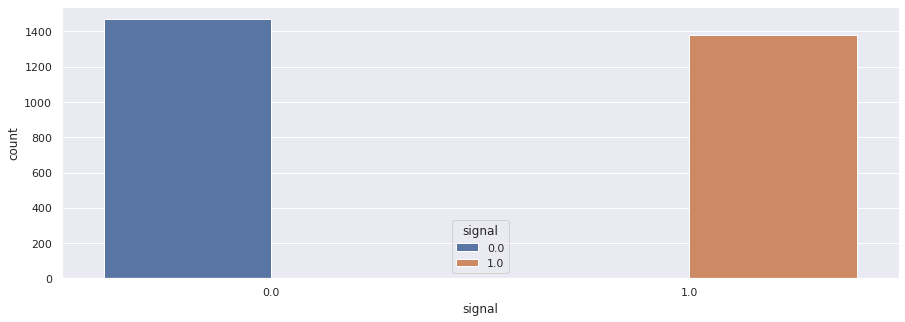

In [22]:
import seaborn as sns
sns.countplot(x = 'signal', data=df, hue='signal')
plt.show()

In [23]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from joblib import Parallel, delayed
# import time

# k = X.copy()
# k = k.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# def calculate_vif_(k, thresh=10.0):
#     variables = [k.columns[i] for i in range(k.shape[1])]
#     dropped=True
#     while dropped:
#         dropped=False
#         print(len(variables))
#         vif = Parallel(n_jobs=-1,verbose=5)(
#             delayed(variance_inflation_factor)(
#                 k[variables].values, ix) 
#             for ix in range(len(variables)))

#         maxloc = vif.index(max(vif))
#         if max(vif) > thresh:
#             print(time.ctime() + ' dropping \'' + k[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
#             variables.pop(maxloc)
#             dropped=True

#     print('Remaining variables:')
#     print([variables])
#     return k[[i for i in variables]]

# z = calculate_vif_(k,10) 

In [24]:
def features():
    X = df.drop( columns = ['signal'], axis=1)
    y = df.signal
    return X,y
X,y = features()
print(X)

                High       Low    Settle    Volume  dailyChange      5EMA     10EMA        rsi   Std_dev         ROC  Williams%R
Date                                                                                                                            
2010-01-25 -0.017964  0.004018  0.011808 -0.210871    -0.999837 -0.006767 -0.007528  56.774968  0.016930 -227.628267 -124.925037
2010-01-26 -0.001355 -0.000138 -0.005428 -0.034143    -1.000074 -0.006320 -0.007130  48.821438  0.014830 -178.964146 -123.799475
2010-01-27 -0.001085 -0.016149 -0.014327  0.222587    -1.000196 -0.008992 -0.008483  45.293716  0.014635  -15.100943 -126.541732
2010-01-28 -0.006927  0.003227 -0.001523 -0.097007    -1.000021 -0.006500 -0.007183  50.802302  0.013324  -93.321114 -124.776103
2010-01-29  0.002325 -0.006852 -0.009289 -0.001901    -1.000129 -0.007430 -0.007574  47.667107  0.009904  -60.413856 -123.579190
...              ...       ...       ...       ...          ...       ...       ...        ...   

In [25]:
gkcv = GapKFold(n_splits=5, gap_before=2, gap_after=1)
for trainIndex, testIndex in gkcv.split(X):
    # print("TRAIN:", trainIndex, "TEST:", testIndex)
    xTrain, xTest = X.values[trainIndex], X.values[testIndex];
    yTrain, yTest = y.values[trainIndex], y.values[testIndex];
# print('Observations: %d' % (len(xTrain) + len(xTest)))
print('Training Observations: %d' % (len(xTrain)))
print('Testing Observations: %d' % (len(xTest)))

Training Observations: 2278
Testing Observations: 569


In [26]:
# Natural Gas continuous contract
print('\033[4mBrent Crude Futures, Continuous Contract\033[0m')
def BCdata():
  BC = quandl.get("CHRIS/ICE_B1", authtoken="LSQpgUzwJRoF667ZpzyL") # natural gas continuous contract 1
  BC = BC.loc['2010-01':,]
  return BC

BC = BCdata()
#print(BC.head()); print(BC.shape)

def collectColumns():
  newDf = BC[['Open', 'High', 'Low', 'Settle', 'Volume']]
  newDf= newDf.fillna(method='ffill')
  return newDf

newDf = collectColumns()
# print(newDf.head()); print()
# print(newDf.isnull().sum()); print()
# print(newDf.describe().transpose())

def plot():
  fig = go.Figure(data=go.Ohlc(x=newDf.index,
                  open=newDf['Open'],
                  high=newDf['High'],
                  low=newDf['Low'],
                  close=newDf['Settle']))

  fig.update_layout(
      title='Brent Crude Futures, Continuous Contract',
      yaxis_title='Price (USD)'
  )
  return fig

fig = plot()
fig.show()

def features():
    df = newDf.copy()  
    df['Settle'] = df['Settle'].pct_change()
    df['High'] = df['High'].pct_change()
    df['Low'] = df['Low'].pct_change()
    df['Volume'] = df['Volume'].pct_change()
    df['dailyChange'] = (df['Settle'] - df['Open']) / df['Open']
    df['5EMA'] = (df['Settle'].ewm(span=5,adjust=True,ignore_na=True).mean())
    df['10EMA'] = (df['Settle'].ewm(span=10,adjust=True,ignore_na=True).mean())
    df['priceDirection'] = (df['Settle'].shift(-1) - df['Settle'])
    
    rsi_period = 14 
    chg = df['Settle'].diff(1)
    gain = chg.mask(chg<0,0)
    loss = chg.mask(chg>0,0)
    avg_gain = gain.ewm(com = rsi_period - 1, min_periods = rsi_period).mean()
    avg_loss = loss.ewm(com = rsi_period - 1, min_periods = rsi_period).mean()
    rs = abs(avg_gain/avg_loss)
    df['rsi'] = 100-(100/(1+ rs))

    df['Std_dev']=  df['Settle'].rolling(5).std()
    df['ROC'] = ((df['Settle'] - df['Settle'].shift(5)) / (df['Settle'].shift(5)))*100
    df['Williams%R'] = (df['High'].max() - df['Settle'])/(df['High'] - df['Low'].min()) * -100

    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    df['signal'] = 0.0
    df['signal'] = np.where((df.loc[:,'priceDirection'] > 0), 1.0, 0.0)
    df.drop(columns =['Open','priceDirection' ], axis=1, inplace=True)
    # df.dropna(inplace=True)
    return df

df = features()
# print(df)

def MLfeatures():
    X = df.drop( columns = ['signal'], axis=1)
    y = df.signal
    return X,y
X,y = MLfeatures()

gkcv = GapKFold(n_splits=5, gap_before=2, gap_after=1)
for trainIndex, testIndex in gkcv.split(X):
    # print("TRAIN:", trainIndex, "TEST:", testIndex)
    xTrain, xTest = X.values[trainIndex], X.values[testIndex];
    yTrain, yTest = y.values[trainIndex], y.values[testIndex];
# print('Observations: %d' % (len(xTrain) + len(xTest)))
print('Training Observations: %d' % (len(xTrain)))
print('Testing Observations: %d' % (len(xTest)))

Brent Crude Futures, Continuous Contract


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Observations: 2278
Testing Observations: 569


In [27]:
xgb = XGBClassifier()
logreg2= LogisticRegressionCV(solver='lbfgs')
knn = KNeighborsClassifier(5)
svcl = SVC()
adb = AdaBoostClassifier()
dtclf = DecisionTreeClassifier(max_depth=5)
rfclf = RandomForestClassifier()

# prepare configuration for cross validation test harness
seed = 42
# prepare models
models = []
models.append(('LR', LogisticRegressionCV(solver='lbfgs', max_iter=5000, cv=10)))
models.append(('XGB', XGBClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('ADB', AdaBoostClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVC', SVC()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    cv_results = model_selection.cross_val_score(model, xTrain, yTrain, cv=gkcv, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    accuracy = "%s: %.2f%% (%.2f)" % (name, cv_results.mean(), cv_results.std())
    #print('Accuracy:')
    print(accuracy)    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LR: 0.75% (0.02)
XGB: 0.73% (0.02)
KNN: 0.66% (0.02)
DT: 0.65% (0.03)
ADB: 0.74% (0.02)
RF: 0.73% (0.02)
SVC: 0.51% (0.02)


In [28]:
eval_set = [(xTrain, yTrain), (xTest, yTest)]

# Hyperparameter optimization
xgb = XGBClassifier()

clf = xgb.fit(xTrain, yTrain, 
              early_stopping_rounds=10,  
              eval_metric="logloss", 
              eval_set=eval_set)

# scores
from  sklearn.metrics import log_loss
log_train = log_loss(np.ravel(yTrain), clf.predict_proba(xTrain)[:,1])
log_valid = log_loss(np.ravel(yTest), clf.predict_proba(xTest)[:,1])


print('\n-----------------------')
print('  logloss train: %.5f'%log_train)
print('  logloss valid: %.5f'%log_valid)
print('-----------------------')

print('\nModel parameters...')
print(xgb.get_params())

[0]	validation_0-logloss:0.659417	validation_1-logloss:0.663776
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.631787	validation_1-logloss:0.640849
[2]	validation_0-logloss:0.608961	validation_1-logloss:0.621857
[3]	validation_0-logloss:0.589912	validation_1-logloss:0.606979
[4]	validation_0-logloss:0.573937	validation_1-logloss:0.594965
[5]	validation_0-logloss:0.560353	validation_1-logloss:0.585245
[6]	validation_0-logloss:0.548655	validation_1-logloss:0.577134
[7]	validation_0-logloss:0.538649	validation_1-logloss:0.570373
[8]	validation_0-logloss:0.53004	validation_1-logloss:0.565034
[9]	validation_0-logloss:0.522484	validation_1-logloss:0.560744
[10]	validation_0-logloss:0.515878	validation_1-logloss:0.556447
[11]	validation_0-logloss:0.510157	validation_1-logloss:0.553226
[12]	validation_0-logloss:0.505076	validation_1-logloss:0.551658
[

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


-----------------------
  logloss train: 0.47663
  logloss valid: 0.54632
-----------------------

Model parameters...
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}


ref: https://xgboost.readthedocs.io/en/latest/parameter.html

- eta [default=0.3, alias: learning_rate]

Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.

- range: [0,1]

- gamma [default=0, alias: min_split_loss]

Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.

- range: [0,∞]

- max_depth [default=6]

Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 is only accepted in lossguided growing policy when tree_method is set as hist and it indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree.

- range: [0,∞] (0 is only accepted in lossguided growing policy when tree_method is set as hist)

- min_child_weight [default=1]

Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be.

- range: [0,∞]

- max_delta_step [default=0]

Maximum delta step we allow each leaf output to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative. Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced. Set it to value of 1-10 might help control the update.

- range: [0,∞]

- subsample [default=1]

Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.

- range: (0,1]

- sampling_method [default= uniform]

The method to use to sample the training instances.

- uniform: each training instance has an equal probability of being selected. Typically set subsample >= 0.5 for good results.

- gradient_based: the selection probability for each training instance is proportional to the regularized absolute value of gradients (more specifically, g2+λh2−−−−−−−√). subsample may be set to as low as 0.1 without loss of model accuracy. Note that this sampling method is only supported when tree_method is set to gpu_hist; other tree methods only support uniform sampling.

- colsample_bytree, colsample_bylevel, colsample_bynode [default=1]

This is a family of parameters for subsampling of columns.

      - All colsample_by* parameters have a range of (0, 1], the default value of 1, and specify the fraction of columns to be subsampled.

      - colsample_bytree is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.

      - colsample_bylevel is the subsample ratio of columns for each level. Subsampling occurs once for every new depth level reached in a tree. Columns are subsampled from the set of columns chosen for the current tree.

      - colsample_bynode is the subsample ratio of columns for each node (split). Subsampling occurs once every time a new split is evaluated. Columns are subsampled from the set of columns chosen for the current level.

      - colsample_by* parameters work cumulatively. For instance, the combination {'colsample_bytree':0.5, 'colsample_bylevel':0.5, 'colsample_bynode':0.5} with 64 features will leave 8 features to choose from at each split.

- lambda [default=1, alias: reg_lambda]

L2 regularization term on weights. Increasing this value will make model more conservative.

- alpha [default=0, alias: reg_alpha]

L1 regularization term on weights. Increasing this value will make model more conservative.

- tree_method string [default= auto]

The tree construction algorithm used in XGBoost. 

- scale_pos_weight [default=1]

Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances). See Parameters Tuning for more discussion. Also, see Higgs Kaggle competition demo for examples: R, py1, py2, py3.

- updater [default= grow_colmaker,prune]

A comma separated string defining the sequence of tree updaters to run, providing a modular way to construct and to modify the trees. This is an advanced parameter that is usually set automatically, depending on some other parameters. However, it could be also set explicitly by a user. The following updaters exist:

    - grow_colmaker: non-distributed column-based construction of trees.

    - grow_histmaker: distributed tree construction with row-based data splitting based on global proposal of histogram counting.

    - grow_local_histmaker: based on local histogram counting.
    - grow_skmaker: uses the approximate sketching algorithm
    - grow_quantile_histmaker: Grow tree using quantized histogram
    - grow_gpu_hist: Grow tree with GPU.
    - sync: synchronizes trees in all distributed nodes.
    - refresh: refreshes tree’s statistics and/or leaf values based on the current data. Note that no random subsampling of data rows is performed.
    - prune: prunes the splits where loss < min_split_loss (or gamma).

In a distributed setting, the implicit updater sequence value would be adjusted to grow_histmaker,prune by default, and you can set tree_method as hist to use grow_histmaker.

- refresh_leaf [default=1]

This is a parameter of the refresh updater. When this flag is 1, tree leafs as well as tree nodes’ stats are updated. When it is 0, only node stats are updated.

- process_type [default= default]

A type of boosting process to run.

    - Choices: default, update
    - default: The normal boosting process which creates new trees.
    - update: Starts from an existing model and only updates its trees. In each boosting iteration, a tree from the initial model is taken, a specified sequence of updaters is run for that tree, and a modified tree is added to the new model. The new model would have either the same or smaller number of trees, depending on the number of boosting iteratons performed. Currently, the following built-in updaters could be meaningfully used with this process type: refresh, prune. With process_type=update, one cannot use updaters that create new trees.

- grow_policy [default= depthwise]

Controls a way new nodes are added to the tree.

Currently supported only if tree_method is set to hist.

    - Choices: depthwise, lossguide
    - depthwise: split at nodes closest to the root.
    - lossguide: split at nodes with highest loss change.
    - max_leaves [default=0]
    - Maximum number of nodes to be added. Only relevant when grow_policy=lossguide is set.
    - max_bin, [default=256]

Only used if tree_method is set to hist.

Maximum number of discrete bins to bucket continuous features.

Increasing this number improves the optimality of splits at the cost of higher computation time.

- predictor, [default=``auto``]

The type of predictor algorithm to use. Provides the same results but allows the use of GPU or CPU.

     - auto: Configure predictor based on heuristics.
     - cpu_predictor: Multicore CPU prediction algorithm.
     - gpu_predictor: Prediction using GPU. Used when tree_method is gpu_hist. When predictor is set to default value auto, the gpu_hist tree method is able to provide GPU based prediction without copying training data to GPU memory. If gpu_predictor is explicitly specified, then all data is copied into GPU, only recommended for performing prediction tasks.

- num_parallel_tree, [default=1] - Number of parallel trees constructed during each iteration. This option is used to support boosted random forest.

monotone_constraints

Constraint of variable monotonicity. See tutorial for more information.

interaction_constraints

Constraints for interaction representing permitted interactions. The constraints must be specified in the form of a nest list, e.g. [[0, 1], [2, 3, 4]], where each inner list is a group of indices of features that are allowed to interact with each other. See tutorial for more information



In [29]:
from sklearn.metrics import accuracy_score

# fit model no training data
model = XGBClassifier()
eval_set = [(xTrain, yTrain), (xTest, yTest)]
model.fit(xTrain, yTrain, eval_metric=["error", "logloss"], 
          early_stopping_rounds=5,eval_set=eval_set, verbose=True)
# make predictions for test data
yPred = model.predict(xTest)
predictions = [round(value) for value in yPred]
# evaluate predictions
accuracy = accuracy_score(np.ravel(yTest), predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


[0]	validation_0-error:0.239245	validation_0-logloss:0.659417	validation_1-error:0.274165	validation_1-logloss:0.663776
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 5 rounds.
[1]	validation_0-error:0.239245	validation_0-logloss:0.631787	validation_1-error:0.274165	validation_1-logloss:0.640849
[2]	validation_0-error:0.239245	validation_0-logloss:0.608961	validation_1-error:0.274165	validation_1-logloss:0.621857
[3]	validation_0-error:0.239245	validation_0-logloss:0.589912	validation_1-error:0.274165	validation_1-logloss:0.606979
[4]	validation_0-error:0.236611	validation_0-logloss:0.573937	validation_1-error:0.274165	validation_1-logloss:0.594965
[5]	validation_0-error:0.23705	validation_0-logloss:0.560353	validation_1-error:0.274165	validation_1-logloss:0.585245
[6]	validation_0-error:0.23705	validation_0-logloss:0.548655	validation_1-error:0.274165	validation_1-logloss:0.57713

<IPython.core.display.Javascript object>

Accuracy: 72.93%


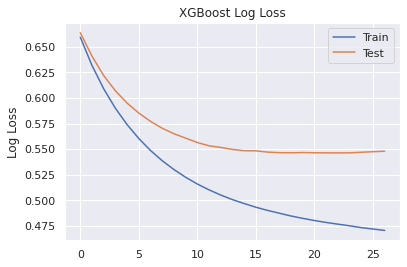

In [30]:
%matplotlib inline

# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()


From reviewing the logloss plot, it looks like there is an opportunity to stop the learning early, perhaps somewhere around epoch 20 to epoch 40.

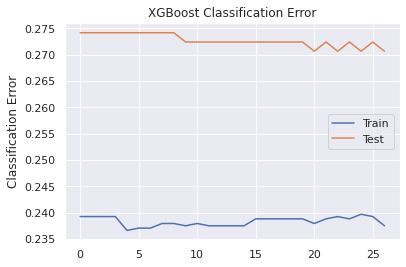

In [31]:
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [32]:
from pprint import pprint
# Check parameters used 
print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}


In [33]:
from sklearn.model_selection import GridSearchCV

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.1, 0.03, 0.05, 0.07], #so called `eta` value
              'max_depth': [3, 5, 6],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100, 200, 300, 500]}

clfGrid = GridSearchCV(model,
                   parameters,
                   cv = gkcv,
                   n_jobs = 5,
                   verbose=True)

clfGrid.fit(xTrain,yTrain)

print(clfGrid.best_score_)
print(clfGrid.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   21.5s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.6min


0.7449566223250434
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100, 'nthread': 4, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.7}


[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:  2.1min finished


In [34]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

weights = (y == 0).sum() / (1.0 * (y == 1).sum())
xgbFinalModel = XGBClassifier(max_depth = 3,
              learning_rate= 0.03,
              min_child_weight= 4, 
              n_estimators= 100,
              nthread= 4, 
              subsample=0.7,
              colsample_bytree=0.7, 
              objective= 'binary:logistic')
results = cross_val_score(xgbFinalModel, xTrain, yTrain, cv=gkcv)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

probabilities = xgbFinalModel.fit(xTrain, yTrain,
                        eval_metric = 'auc').predict_proba(xTest)
print('AUPRC = {}'.format(round(average_precision_score(yTest, \
                                              probabilities[:, 1])*100, 2).astype(str) + '%'))

Accuracy: 74.50% (2.04%)
AUPRC = 77.57%


Use area under ROC as a base metric for deciding best tuned model 

This metric is a measure of how well sorted your classes are - the higher the value, the easier and more effective it is to tune the confidence level later.

In [35]:
pip install scikit-plot

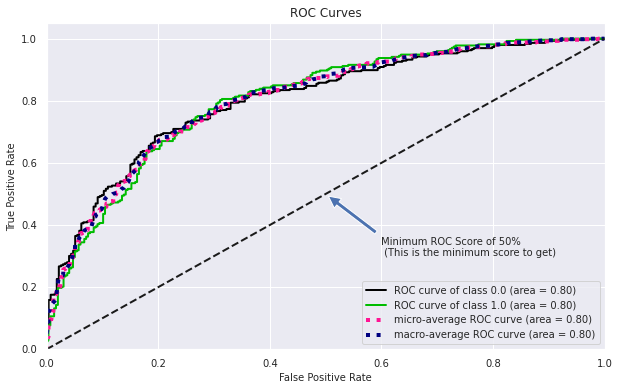

In [36]:
import scikitplot as skplt #to make things easy
yPred = xgbFinalModel.predict_proba(xTest)
plt.rcParams['figure.figsize'] = [10, 6]
skplt.metrics.plot_roc(yTest, yPred)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', 
             xy=(0.5, 0.5), 
             xytext=(0.6, 0.3),
             arrowprops=dict(shrink=0.05),
                )
plt.show()

In [37]:
from sklearn.metrics import explained_variance_score
predictions = xgbFinalModel.predict(xTest)
predictions[-1:]
#print((round(explained_variance_score(predictions,y_test),2)*100).astype(str) + '%')

array([1.])

Our trading strategy waits for a positively predicted outcome to buy S&P 500 at the Opening price, and sell it at the Closing price, so our hope is to have the lowest False positives rate to avoid losses. In other words, we expect our model would have the highest precision rate.

In [38]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar() )

In [39]:
# predictions = pd.DataFrame(predictions[-5:])
# predictions.rename(columns = {0: 'predicted'}, inplace=True)
# d = yTest.tail()
# d.reset_index(inplace=True)
# d = d.append(pd.DataFrame({'Date': pd.date_range(start=d.Date.iloc[-1], 
#                                              periods=2, freq='B', closed='right')}))
# d.set_index('Date', inplace=True)
# predictions.index = d.tail().index
# predictions.tail(1)

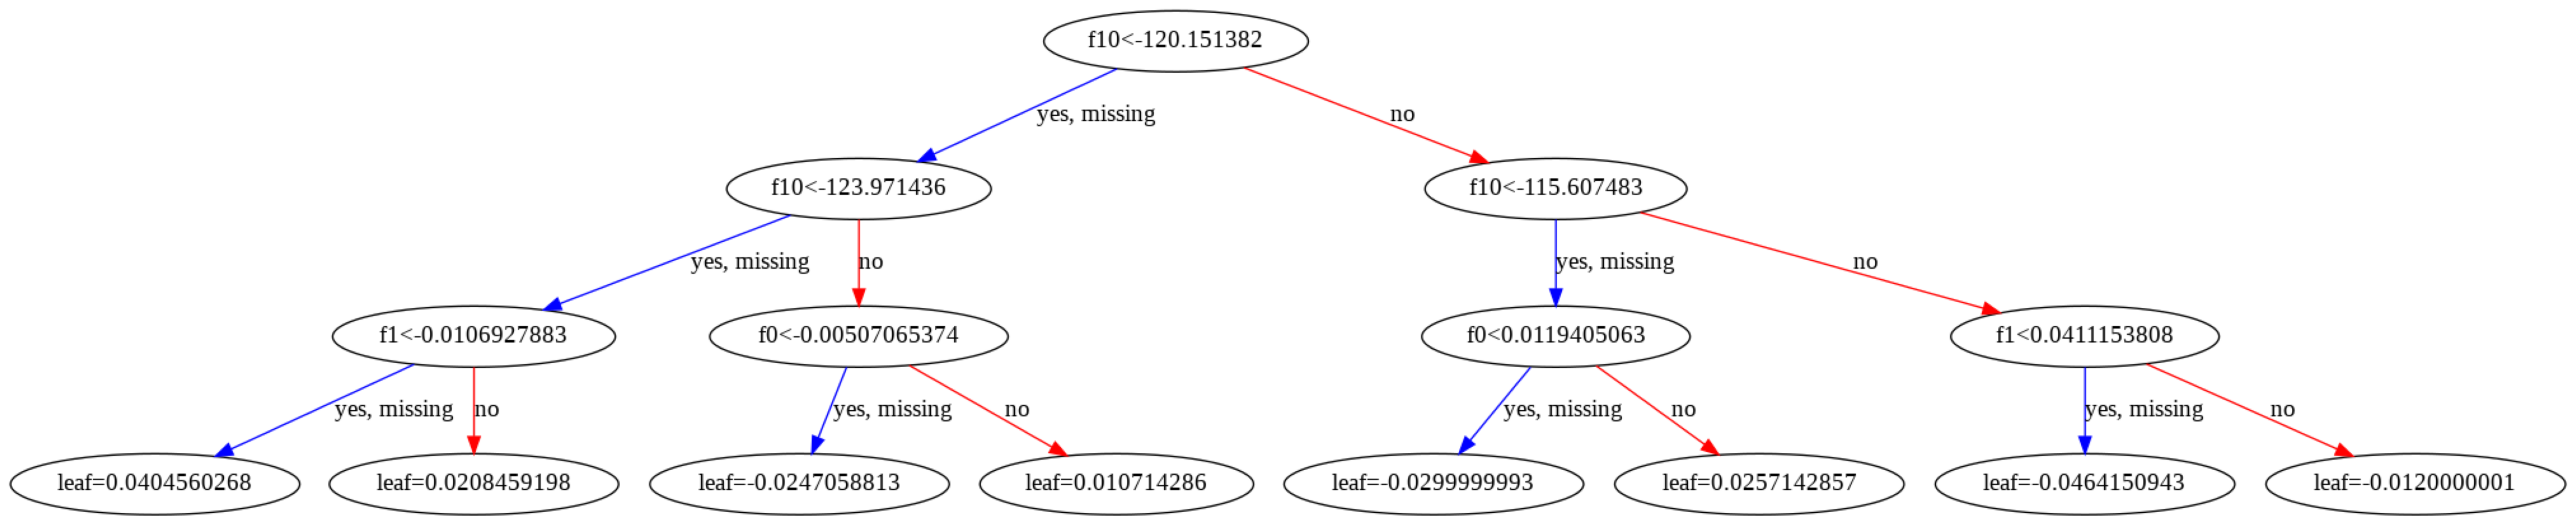

In [40]:
import graphviz
import xgboost as xgb
from xgboost import plot_tree
from matplotlib.pylab import rcParams
import os 
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
rcParams['figure.figsize'] = 80,50
xgb.plot_tree(xgbFinalModel)
plt.show()

In [41]:
pip install shap

     |████████████████████████████████| 358kB 9.0MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491617 sha256=58aaac437193c78e95c619bc3afa1a460a63319c38e8a164020b8ea1b46fa4a2
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


<IPython.core.display.Javascript object>

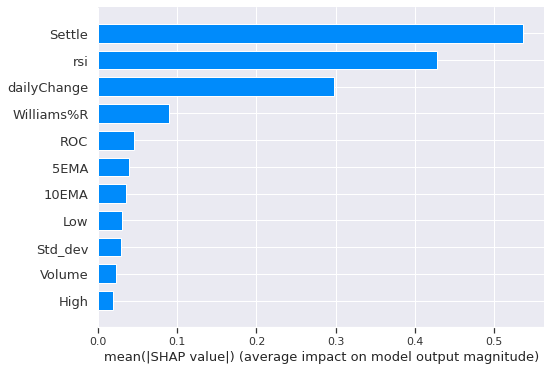

In [42]:
import shap

xTest = pd.DataFrame(xTest)
xTest.columns = df.columns[:-1]
shap_values = shap.TreeExplainer(xgbFinalModel).shap_values(xTest)
shap.summary_plot(shap_values, xTest, plot_type="bar")

In [43]:
!pip install eli5
from eli5.sklearn import PermutationImportance

     |████████████████████████████████| 112kB 8.4MB/s 


The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


In [44]:
import eli5
# let's check the importance of each attributes
perm = PermutationImportance(xgbFinalModel, random_state = 0).fit(xTest.values, yTest)
eli5.show_weights(perm, feature_names = xTest.columns.tolist())

Weight,Feature
0.0299 ± 0.0241,Settle
0.0151 ± 0.0170,rsi
0.0088 ± 0.0165,dailyChange
0.0028 ± 0.0028,Low
0.0018 ± 0.0031,10EMA
0.0014 ± 0.0034,Williams%R
0.0014 ± 0.0041,5EMA
0.0011 ± 0.0028,ROC
0.0007 ± 0.0017,Volume
0.0004 ± 0.0014,High


In [45]:
perm_train = PermutationImportance(xgbFinalModel, scoring='accuracy',
                                   n_iter=100, random_state=1)
# fit and see the permuation importances
perm_train.fit(xTrain, yTrain)
eli5.explain_weights_df(perm_train, feature_names=df.columns[:-1].tolist()).head()

,feature,weight,std
0,rsi,0.022072,0.006058
1,Settle,0.021365,0.005750
2,Volume,0.000913,0.000668
3,Low,0.000768,0.000822
4,High,0.000663,0.000764


<IPython.core.display.Javascript object>

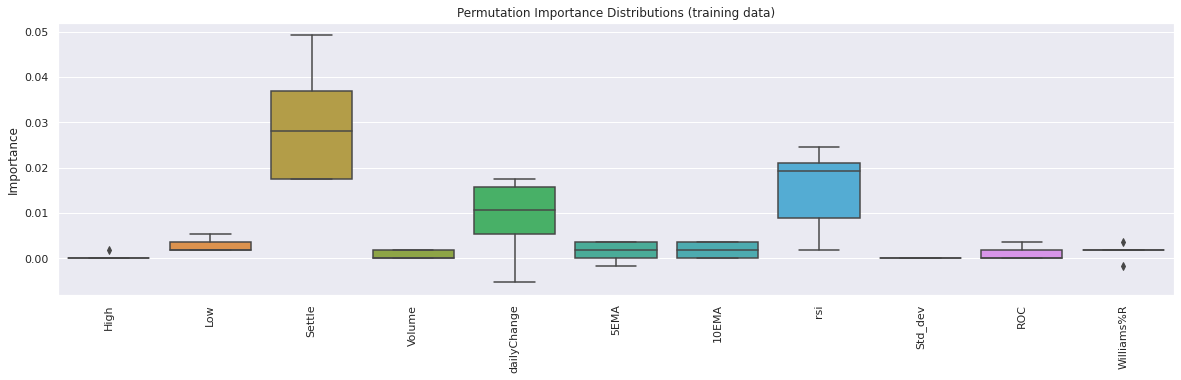

In [46]:
# figure size in inches
from matplotlib import rcParams
rcParams['figure.figsize'] = 20,5

perm_train_df = pd.DataFrame(data=perm.results_,
                                      columns=df.columns[:-1])
(sns.boxplot(data=perm_train_df)
        .set(title='Permutation Importance Distributions (training data)',
             ylabel='Importance'));
plt.xticks(rotation=90)
plt.show()

In [47]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()
# j will be the record we explain
j = 1

explainerXGB = shap.TreeExplainer(xgbFinalModel)
shap_values_XGB_test = explainerXGB.shap_values(xTest)
shap.force_plot(explainerXGB.expected_value, shap_values_XGB_test[j], xTest.iloc[[j]])

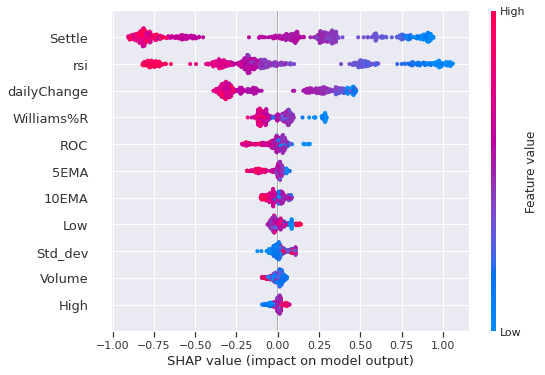

In [48]:
shap.summary_plot(shap_values, xTest)

In [49]:
# from xgboost import plot_importance
# plt.rcParams['figure.figsize'] = [12, 8]
# # plot feature importance
# plot_importance(xgbFinalModel)
# plt.show()

Measuring feature importance by:
- Weight. The number of times a feature is used to split the data across all trees.
- Cover. The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.
- Gain. The average training loss reduction gained when using a feature for splitting.

In [50]:
xgbFinalModel.get_booster().get_score(importance_type='weight') 

{'f0': 25,
 'f1': 53,
 'f10': 51,
 'f2': 125,
 'f3': 40,
 'f4': 65,
 'f5': 30,
 'f6': 35,
 'f7': 144,
 'f8': 39,
 'f9': 49}

In [51]:
xgbFinalModel.get_booster().get_score(importance_type='cover') 

{'f0': 107.44737271200003,
 'f1': 95.33694201320758,
 'f10': 155.4101594490196,
 'f2': 206.34437007384003,
 'f3': 85.60502836250001,
 'f4': 183.05420314615387,
 'f5': 130.36604314333331,
 'f6': 116.21134140000001,
 'f7': 179.50091114027776,
 'f8': 82.55950443461536,
 'f9': 81.80794054489793}

In [52]:
xgbFinalModel.get_booster().get_score(importance_type='gain')

{'f0': 5.834575593199999,
 'f1': 4.141731135439621,
 'f10': 13.568220256117648,
 'f2': 37.16582455724001,
 'f3': 4.628858326574999,
 'f4': 42.83116207409232,
 'f5': 6.272666939666667,
 'f6': 4.446576908828571,
 'f7': 24.828352809479185,
 'f8': 4.717324574333334,
 'f9': 4.738222677285714}

In [53]:
import sklearn.metrics as metrics

In [54]:
from sklearn.metrics import cohen_kappa_score, recall_score, roc_auc_score

# make predictions for train data and evaluate
yPred = xgbFinalModel.predict(xTrain)
auc = round(roc_auc_score(yTrain, xgbFinalModel.predict(xTrain))*100,2).astype(str) + '%'
print("Performance (train data) : ", auc)

# make predictions for test data and evaluate
auc = round(roc_auc_score(yTest, xgbFinalModel.predict(xTest.values))*100,2).astype(str) + '%'
print("Performance (test data) : ", auc)
print('*'*60)

print ("\nModel Report (test data):-")
print( 'Cohen Kappa: '+ str(np.round(cohen_kappa_score(yTest, xgbFinalModel.predict(xTest.values))*100,2).astype(str) + '%'))
print('Recall: ', round(recall_score(yTest, xgbFinalModel.predict(xTest.values))*100, 2).astype(str) + '%')
print('*'*60)
print('\n Classification Report (test data):-\n', classification_report(yTest, xgbFinalModel.predict(xTest.values)))

Performance (train data) :  76.57%
Performance (test data) :  72.95%
************************************************************

Model Report (test data):-


<IPython.core.display.Javascript object>

Cohen Kappa: 46.0%
Recall:  68.86%
************************************************************

 Classification Report (test data):-
               precision    recall  f1-score   support

         0.0       0.73      0.77      0.75       296
         1.0       0.73      0.69      0.71       273

    accuracy                           0.73       569
   macro avg       0.73      0.73      0.73       569
weighted avg       0.73      0.73      0.73       569



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

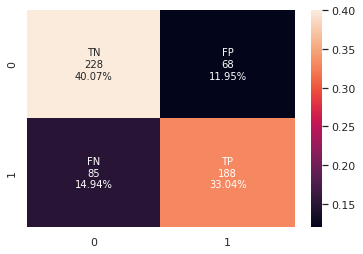

In [55]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report 

results = confusion_matrix(yTest, xgbFinalModel.predict(xTest.values)) 
names = ['TN','FP','FN','TP']
counts = ['{0:0.0f}'.format(value) for value in
                results.flatten()]
percentages = ['{0:.2%}'.format(value) for value in
                     results.flatten()/np.sum(results)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(names, counts, percentages)]
labels = np.asarray(labels).reshape(2,2)


plt.figure(figsize=(6,4))
sns.heatmap(results/np.sum(results), 
            annot=labels, 
            fmt='')
plt.show()

 - False positives are cases where the model predicts a positive outcome whereas the real outcome from the testing set is negative. 
 - Vice versa, False negatives are cases where the model predicts a negative outcome where the real outcome from the test set is positive.
 - Our trading strategy waits for a positively predicted outcome to buy crude oil at the Opening price, and sell it at the Closing price, so our hope is to have the lowest False positives rate to avoid losses. 
 - In other words, we expect our model would have the highest precision rate.

Learning curves constitute a great tool to do a quick check on our models at every point in our machine learning workflow. 

When we build a model to map the relationship between the features  and the target , we assume that there is such a relationship in the first place.

The gap between the learning curves suggests some amount of variance in data. The low training AUPRC score corroborate this diagnosis of variance. The large gap and the low training error also indicates slightly overfitting problem. One more important observation we can make here is that adding new training instances is very likely to lead to better models. The validation curve doesn’t plateau at the maximum training set size used. It still has potential to decrease and converge toward the training curve. So far, we can conclude that our learning algorithm (XGB) suffers from slight variance and quite a low bias, there slightly overfitting the training data. Adding more training instances is very likely to lead to better models under the current learning algorithm.

At this point, here are a couple of things we could do to improve our model:
Adding more training instances.
Increase the regularization for our current learning algorithm. This should decrease the variance and increase the bias.

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


<bound method Visualizer.poof of LearningCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ea13ba290>,
              cv=GapKFold(gap_after=1, gap_before=2, n_splits=5),
              exploit_incremental_learning=False, groups=None, model=None,
              n_jobs=1, pre_dispatch='all', random_state=None,
              scoring='f1_weighted', shuffle=False,
              train_sizes=array([0.1  , 0.325, 0.55 , 0.775, 1.   ]))>

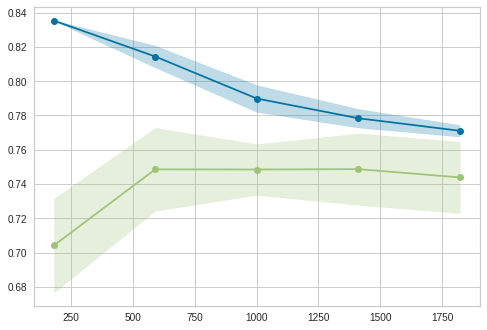

In [56]:
from yellowbrick.model_selection import LearningCurve
visualizer = LearningCurve(xgbFinalModel, scoring= 'f1_weighted', cv=gkcv)
visualizer.fit(xTrain, yTrain)
visualizer.poof

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

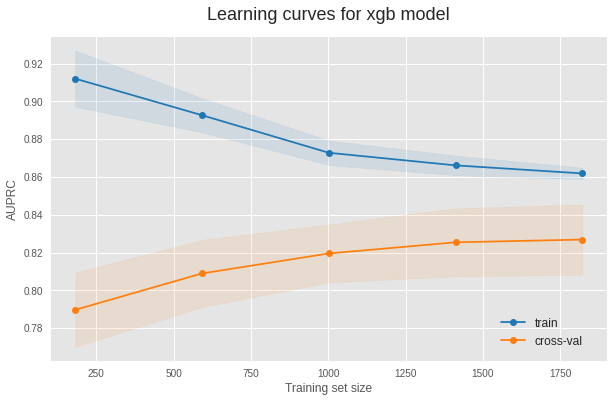

In [57]:
from sklearn.model_selection import learning_curve

train_size, train_score, cv_score = learning_curve(\
XGBClassifier(max_depth = 3,
              learning_rate= 0.03,
              min_child_weight= 4, 
              n_estimators= 100,
              nthread= 4, 
              subsample=0.7,
              colsample_bytree=0.7, 
              objective= 'binary:logistic'), 
              xTrain,\
              np.ravel(yTrain), 
              scoring = 'average_precision')

mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)
mean_cv = np.mean(cv_score, axis=1)
std_cv = np.std(cv_score, axis=1)

colours = plt.cm.tab10(np.linspace(0, 1, 9))

fig = plt.figure(figsize = (10, 6))
plt.style.use('ggplot')
plt.fill_between(train_size, 
                 (mean_train_score - std_train_score),
                 (mean_train_score + std_train_score), 
                 alpha=0.1, 
                 color=colours[0])
plt.fill_between(train_size, 
                 (mean_cv - std_cv),
                 (mean_cv + std_cv), 
                 alpha=0.1, 
                 color=colours[1])
plt.plot(train_size, 
         train_score.mean(axis = 1), 
         'o-', 
         label = 'train', \
         color = colours[0])
plt.plot(train_size, 
         cv_score.mean(axis = 1), 
         'o-', 
         label = 'cross-val', \
         color = colours[1])

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], 
           bbox_to_anchor=(0.8, 0.15), \
           loc=2, 
           borderaxespad=0, 
           fontsize = 12)
plt.xlabel('Training set size', size = 12) 
plt.ylabel('AUPRC', size = 12)
plt.title('Learning curves for xgb model', fontsize = 18, y = 1.03)
plt.show()

A narrow gap indicates low variance. Generally, the more narrow the gap, the lower the variance. The opposite is also true: the wider the gap, the greater the variance. Let’s now explain why this is the case. As we’ve discussed earlier, if the variance is high, then the model fits training data too well. When training data is fitted too well, the model will have trouble generalizing on data that hasn’t seen in training. When such a model is tested on its training set, and then on a validation set, the training error will be low and the validation error will generally be high. As we change training set sizes, this pattern continues, and the differences between training and validation errors will determine that gap between the two learning curves.

The relationship between the training and validation error, and the gap can be summarized this way:  So the bigger the difference between the two errors, the bigger the gap. The bigger the gap, the bigger the variance. In our case, the gap is moderately narrow and getting narrower, so we can conclude that the variance is low. High training errors are also a quick way to detect low variance. If the variance of a learning algorithm is low, then the algorithm will come up with simplistic and similar models as we change the training sets. Because the models are overly simplified, they cannot even fit the training data well (they underfit the data).

- Adding more instances (rows) to the training data is hugely unlikely to lead to better models under the current learning algorithm.
- Increasing the regularization of the current learning algorithm, if that’s the case. In a nutshell, regularization prevents the algorithm from fitting the training data too well. If we increase regularization, the model will fit training data better, and, as a consequence, the variance will decrease and the bias will increase which will eventually reduce the gap to narrow it down.
- Adding more features.
- Feature selection.
- Hyperparameter optimization.